In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [4]:
## Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [5]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [6]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:
# os.chdir('./drive')
import os
os.listdir()

['.config', 'gdrive', 'adc.json', 'drive', 'sample_data']

In [8]:
# suppose you make a directory called "try_colab" under your google drive
# you can change this path to the directory you want to work at 
path = './drive/STATSM231A/HW2' 
os.chdir(path)

os.listdir('./')

['PyTorch_CIFAR10', 'GRU_Prediction', 'hw2_ResNet.ipynb']

In [9]:
# Get into the folder
os.chdir('GRU_Prediction')
os.listdir('./')

['floyd.yml',
 'README.md',
 'main.ipynb',
 '.ipynb_checkpoints',
 'data',
 'hw2_part2.ipynb']

In [9]:
# install package pytorch lightening
! pip install pytorch-lightning
  

     |████████████████████████████████| 925 kB 5.4 MB/s 
     |████████████████████████████████| 282 kB 43.9 MB/s 
     |████████████████████████████████| 596 kB 35.7 MB/s 
     |████████████████████████████████| 125 kB 37.9 MB/s 
     |████████████████████████████████| 829 kB 38.3 MB/s 
     |████████████████████████████████| 1.3 MB 35.3 MB/s 
     |████████████████████████████████| 271 kB 49.7 MB/s 
     |████████████████████████████████| 160 kB 48.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=b3be5a280d7759a9efe77ba71e7e56fcd0f451a40a91c923ddef168cda02a0eb
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [10]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

# Define data root directory
data_dir = "./data/"
print(os.listdir(data_dir))

['FE_hourly.csv', 'NI_hourly.csv', 'AEP_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'pjm_hourly_est.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'est_hourly.paruqet', 'COMED_hourly.csv', 'PJM_Load_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv']


In [11]:
pd.read_csv(data_dir + 'AEP_hourly.csv').head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [12]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in tqdm_notebook(os.listdir(data_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(data_dir + file, parse_dates=[0])
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/14 [00:00<?, ?it/s]

In [13]:
print(train_x.shape)

(980185, 90, 5)


In [14]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [15]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [16]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(RNNNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
    
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [17]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 3
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    elif model_type =="RNN":
        model = RNNNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            elif model_type == "RNN":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.time()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.time()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [18]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.006723960100789555
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.003778933199500898
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.0026900990988360718
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.0021090943437229726
Epoch 1/5 Done, Total Loss: 0.001814692915859924
Time Elapsed for Epoch: 424.8928668498993 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.00026044115191325545
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.00025354382167279253
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.0002462592083126462
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.00023494562336054514
Epoch 2/5 Done, Total Loss: 0.0002296178826362541
Time Elapsed for Epoch: 427.52639865875244 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.00018029897510132286
Epoch 3......Step: 400/957....... Average Loss 

In [19]:
lr = 0.0005
rnn_model = train(train_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.007825068300007842
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.004532713477674406
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.003269748411451777
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.002606872592587024
Epoch 1/5 Done, Total Loss: 0.002270804439536797
Time Elapsed for Epoch: 188.2290108203888 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0005015869421185926
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.00047983195901906583
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00045718811006130027
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.0004378778384489124
Epoch 2/5 Done, Total Loss: 0.00042479762681219783
Time Elapsed for Epoch: 187.57899951934814 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.0003360826219432056
Epoch 3......Step: 400/957....... Average Loss for

In [20]:
lr = 0.001
lstm_model = train(train_loader, lr, model_type="LSTM")

Starting Training of LSTM model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.013513392191380263
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.00799180569301825
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.0057114525471115484
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.004504368546549813
Epoch 1/5 Done, Total Loss: 0.003882813297942974
Time Elapsed for Epoch: 485.8521180152893 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0006090952103841119
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.0005725815436017001
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.0005455528105570314
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.000520132119054324
Epoch 2/5 Done, Total Loss: 0.0005028343174298554
Time Elapsed for Epoch: 472.6978933811188 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.00039107863281969915
Epoch 3......Step: 400/957....... Average Loss for Ep

In [21]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 10.916303157806396
sMAPE: 0.3315111101858751%


In [22]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 14.322905778884888
sMAPE: 0.3231259724651445%


In [23]:
rnn_outputs, targets, rnn_sMAPE = evaluate(rnn_model, test_x, test_y, label_scalers)

Evaluation Time: 3.8818819522857666
sMAPE: 0.3264122830750916%


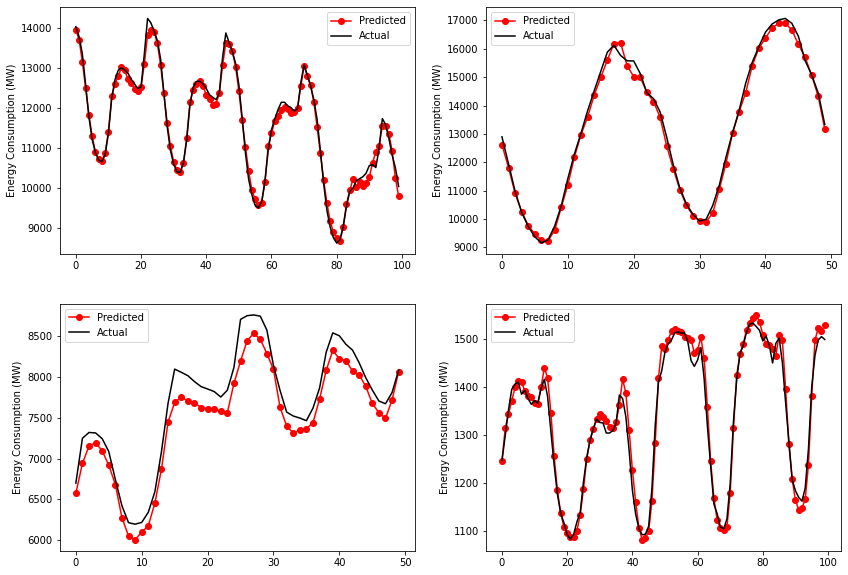

In [24]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="r", label="Predicted")
plt.plot(targets[0][-100:], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[8][-50:], "-o", color="r", label="Predicted")
plt.plot(targets[8][-50:], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[4][:50], "-o", color="r", label="Predicted")
plt.plot(targets[4][:50], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,4)
plt.plot(lstm_outputs[6][:100], "-o", color="r", label="Predicted")
plt.plot(targets[6][:100], color="k", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()
